In [1]:
from TradeGenerator import *
import matplotlib.pyplot as plt

In [2]:
file_name="rawTrade.csv"
import os.path
import pandas as pds


In [3]:
if( os.path.isfile(file_name)  ):
    df = pds.read_csv(file_name)
else:
    t = TradeGenerator()
    tList = t.prepareTradeList(100)
    df = t.tradeListConvert2DataFrame(tList)
    df.to_csv(file_name)

In [4]:
df["total"]=df["price"] * df["quantity"]

In [5]:
from datetime import date

In [6]:
df.columns

Index(['Unnamed: 0', 'cust', 'orgType', 'price', 'quantity', 'secid',
       'tradeId', 'total'],
      dtype='object')

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.core.debugger import set_trace

class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute): # no *args or **kargs
        self.attribute = attribute
    def fit(self, X):
        return self  # nothing else to do
    def transform(self, X, y=None):
        #set_trace()
        _encoded, _categories = X[self.attribute].factorize()
        self.categoriesIndex = _categories
        X[self.attribute+"_cat"] = _encoded
        X.drop(self.attribute,axis=1 ,inplace=True)
        return X
        

In [8]:
OrgTypeCategoryEncoder = CategoryEncoder("orgType")
CustCategoryEncoder = CategoryEncoder("cust")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('OrgType', OrgTypeCategoryEncoder),
        ('Cust', CustCategoryEncoder)
    ])

In [9]:
newdf=num_pipeline.fit_transform(df)

In [10]:
newdf=newdf.drop("tradeId",axis=1)

In [11]:
(row,col)=newdf.shape
data = np.zeros((len(CustCategoryEncoder.categoriesIndex),col), dtype=np.float32)
for c in range(len(CustCategoryEncoder.categoriesIndex)):
    custClassSet = newdf[ newdf["cust_cat"] ==c ]
    
    for j in range(0,col):
        data[c,j] = np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"] )


In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(data)

In [13]:
ll=pd.DataFrame(kmeans.labels_)

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot2DCluster(kmeans,data,xaxis,yaxis,axisIndex,subplot=111):
    ll=pd.DataFrame(kmeans.labels_)
    numOfCluster = kmeans.n_clusters
    
    plt.subplot(subplot)
    colors = cm.rainbow(np.linspace(0, 1, numOfCluster))
    for c in range(0,numOfCluster):
        d = data[ll[0]==c]
        plt.scatter(d[:,xaxis],d[:,yaxis],c=colors[c],marker="o")
        plt.scatter(kmeans.cluster_centers_[c,xaxis],kmeans.cluster_centers_[c,yaxis],c=colors[c],marker="x")
        
    # rotate the axes and update
    plt.xlabel(axisIndex[xaxis], fontsize=14)
    plt.ylabel(axisIndex[yaxis], fontsize=14)
    #ax.set_zlabel("restaurant", fontsize=14)
    

def plot3DCluster(kmeans,data,xaxis,yaxis,zaxis,axisIndex):
    ll=pd.DataFrame(kmeans.labels_)
    numOfCluster = kmeans.n_clusters
    
   
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, numOfCluster))
    for c in range(0,numOfCluster):
        d = data[ll[0]==c] #select the data of cluster
        ax.scatter(d[:,xaxis],d[:,yaxis],d[:,zaxis],c=colors[c],marker="o")
        ax.scatter(kmeans.cluster_centers_[c,xaxis],kmeans.cluster_centers_[c,yaxis],kmeans.cluster_centers_[c,zaxis],c=colors[c],marker="x")
        
    # rotate the axes and update
    ax.set_xlabel(axisIndex[xaxis], fontsize=14)
    ax.set_ylabel(axisIndex[yaxis], fontsize=14)
    ax.set_zlabel(axisIndex[zaxis], fontsize=14)
    #plt.show()

In [15]:
OrgTypeCategoryEncoder.categoriesIndex

Index(['tech', 'Gov', 'energy', 'restaurant', 'airline'], dtype='object')

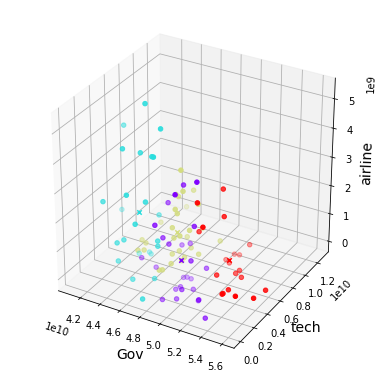

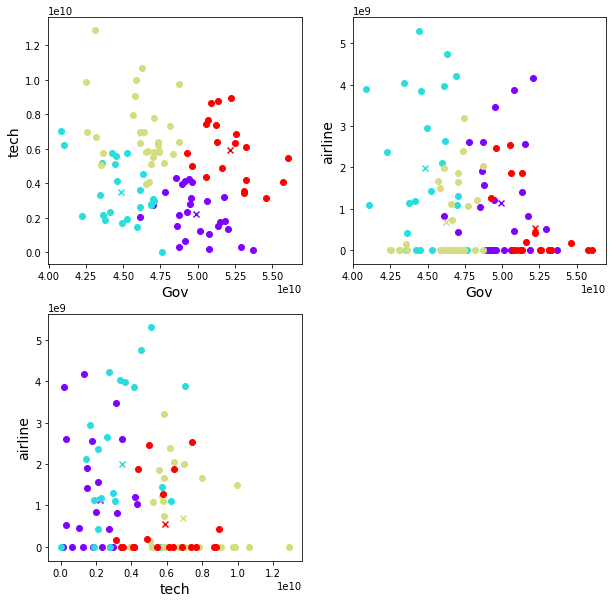

In [16]:
fig = plt.figure(figsize=(5, 5))
plot3DCluster(kmeans,data,1,0,4,OrgTypeCategoryEncoder.categoriesIndex)
plt.show()
fig = plt.figure(figsize=(10, 10))
plot2DCluster(kmeans,data,1,0,OrgTypeCategoryEncoder.categoriesIndex,221)
plot2DCluster(kmeans,data,1,4,OrgTypeCategoryEncoder.categoriesIndex,222)
plot2DCluster(kmeans,data,0,4,OrgTypeCategoryEncoder.categoriesIndex,223)
plt.show()